# Image classifier project

In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.preprocessing.image import img_to_array
import random

In [5]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path
train_dir = "../data/raw/train/"

#Filtro
dog_image_files = [f for f in os.listdir(train_dir) if f.startswith("dog")]

dog_images = []
for i in range(min(9, len(dog_image_files))):  #Control numeración imagenes
    img_path = os.path.join(train_dir, dog_image_files[i])
    img = image.load_img(img_path)  # Carga
    img_array = image.img_to_array(img) / 255.0  # Conversion a array
    dog_images.append(img_array)


plt.figure(figsize=(12, 8))
for i in range(len(dog_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(dog_images[i])
    plt.title("Perretes")
    plt.axis("off")

plt.tight_layout()
plt.show()


IsADirectoryError: [Errno 21] Is a directory: '../data/raw/train/dogs'

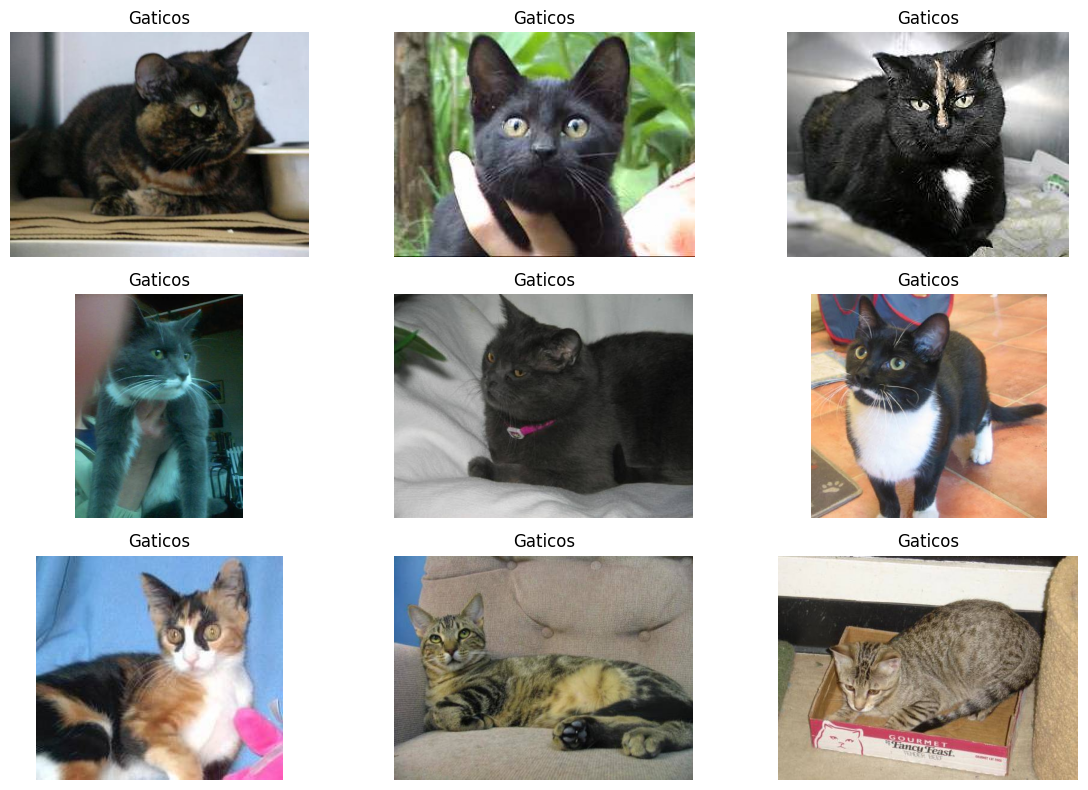

In [ ]:

cat_image_files = [f for f in os.listdir(train_dir) if f.startswith("cat")]

cat_images = []
for i in range(min(9, len(cat_image_files))):  #Control numeración imagenes
    img_path = os.path.join(train_dir, cat_image_files[i])
    img = image.load_img(img_path)  # Carga
    img_array = image.img_to_array(img) / 255.0  # Conversion a array
    cat_images.append(img_array)


plt.figure(figsize=(12, 8))
for i in range(len(cat_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cat_images[i])
    plt.title("Gaticos")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Crear los datasets de las imagenes de perros y gatos

In [ ]:
import numpy as np
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

train_dir = '../data/raw/train'  
tamano = (200, 200)
batch_size = 128 

image_files = []
labels = []


for file in os.listdir(train_dir):
    if file.endswith(".jpg") or file.endswith(".png"):
        image_files.append(os.path.join(train_dir, file))
        
        if 'cat' in file:
            labels.append(0)  
        elif 'dog' in file:
            labels.append(1)  


labels = np.array(labels)

indices = np.arange(len(image_files))
np.random.shuffle(indices)
image_files = np.array(image_files)[indices]
labels = labels[indices]

class ImageDataLoader(tf.keras.utils.Sequence):
    def __init__(self, image_files, labels, batch_size, target_size):
        self.image_files = image_files
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))  

    def __getitem__(self, idx):
        batch_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for file in batch_files:
            img = tf.keras.preprocessing.image.load_img(file, target_size=self.target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  
            images.append(img_array)

        return np.array(images), np.array(batch_labels)


train_generator = ImageDataLoader(image_files, labels, batch_size, tamano)

for i in range(3):
    batch_images, batch_labels = train_generator[i]
    print(f"Lote {i+1}: {batch_images.shape} imágenes, {batch_labels.shape} etiquetas")
    print(f"Primeras 10 etiquetas del lote {i+1}: {batch_labels[:10]}")


Lote 1: (128, 200, 200, 3) imágenes, (128,) etiquetas
Primeras 10 etiquetas del lote 1: [0 1 1 0 0 0 1 0 0 1]
Lote 2: (128, 200, 200, 3) imágenes, (128,) etiquetas
Primeras 10 etiquetas del lote 2: [1 1 1 0 0 0 1 0 1 1]
Lote 3: (128, 200, 200, 3) imágenes, (128,) etiquetas
Primeras 10 etiquetas del lote 3: [0 1 0 1 1 0 1 1 1 1]


In [8]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorio raíz de entrenamiento
train_dir = '../data/raw/train'  

# Crear subdirectorios para cada clase si aún no están organizados
cat_dir = os.path.join(train_dir, "cats")
dog_dir = os.path.join(train_dir, "dogs")

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Mover archivos solo si están en la raíz y no en la carpeta correcta
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    
    if os.path.isfile(file_path):  # Asegurar que no es un directorio
        if file.startswith("cat") and not os.path.exists(os.path.join(cat_dir, file)):
            shutil.move(file_path, os.path.join(cat_dir, file))
        elif file.startswith("dog") and not os.path.exists(os.path.join(dog_dir, file)):
            shutil.move(file_path, os.path.join(dog_dir, file))

# Generador de datos con normalización y división de validación
train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

# Cargar imágenes en lotes desde los subdirectorios
train_generator = train_datagen.flow_from_directory(
    train_dir,  
    target_size=(200, 200),  
    batch_size=32,
    class_mode='binary',  
    subset='training'  # 80% para entrenamiento
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 20% para validación
)

# Verificar las clases detectadas
print(f"Clases detectadas: {train_generator.class_indices}")
print(f"Número de imágenes en entrenamiento: {train_generator.samples}")
print(f"Número de imágenes en validación: {val_generator.samples}")




Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Clases detectadas: {'cats': 0, 'dogs': 1}
Número de imágenes en entrenamiento: 20000
Número de imágenes en validación: 5000


## Modelado y entrenamiento

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir la arquitectura de la CNN
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 99, 99, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 64)      

In [11]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=100,  # Limita el número de lotes procesados por época
    validation_steps=50  
)

# Guardar el modelo entrenado
model.save('cats_vs_dogs_cnn.h5')


Epoch 1/10


2025-03-06 12:23:03.202311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.6219

2025-03-06 12:23:31.999591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 34s 341ms/step - loss: 0.6529 - accuracy: 0.6219 - val_loss: 0.6343 - val_accuracy: 0.6456
Epoch 2/10
100/100 [==============================] - 36s 358ms/step - loss: 0.6193 - accuracy: 0.6650 - val_loss: 0.6114 - val_accuracy: 0.6837
Epoch 3/10
100/100 [==============================] - 38s 384ms/step - loss: 0.6060 - accuracy: 0.6719 - val_loss: 0.5872 - val_accuracy: 0.6913
Epoch 4/10
100/100 [==============================] - 43s 433ms/step - loss: 0.5900 - accuracy: 0.6850 - val_loss: 0.5817 - val_accuracy: 0.6869
Epoch 5/10
100/100 [==============================] - 40s 402ms/step - loss: 0.5744 - accuracy: 0.7103 - val_loss: 0.5623 - val_accuracy: 0.7244
Epoch 6/10
100/100 [==============================] - 37s 362ms/step - loss: 0.5739 - accuracy: 0.6978 - val_loss: 0.5569 - val_accuracy: 0.7262
Epoch 7/10
100/100 [==============================] - 35s 352ms/step - loss: 0.5619 - accuracy: 0.7216 - val_loss: 0.5410 - val_accuracy: 0.7

### Análisis de los resultados: 

1- Hemos pasado de un valor inicial de 62% a 73% en accuracy

2- La validación ha pasado de un 65% a un 75%

3- La pérdida de datos decrece, lo que significa que el modelo está aprendiendo

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento', color='blue')
plt.plot(epochs_range, val_acc, label='Precisión Validación', color='red')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la Precisión')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento', color='blue')
plt.plot(epochs_range, val_loss, label='Pérdida Validación', color='red')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()

plt.show()


## Mejorando el modelo

- Uso de RMSprop
- Aumentar numero de capas
- Aumentar numero de épocas



In [16]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),  # Agregar una capa más
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),  # Otra capa más
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Aumentar la cantidad de neuronas
    layers.Dropout(0.5),  # Para evitar sobreajuste
    layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,  
    steps_per_epoch=100,
    validation_steps=50
)

Epoch 1/25


2025-03-06 12:34:31.022275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5150

2025-03-06 12:36:15.091802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


100/100 [==============================] - 120s 1s/step - loss: 0.6914 - accuracy: 0.5150 - val_loss: 0.6859 - val_accuracy: 0.5625
Epoch 2/25
100/100 [==============================] - 99s 986ms/step - loss: 0.6752 - accuracy: 0.5756 - val_loss: 0.6654 - val_accuracy: 0.5850
Epoch 3/25
100/100 [==============================] - 98s 982ms/step - loss: 0.6370 - accuracy: 0.6297 - val_loss: 0.6196 - val_accuracy: 0.6550
Epoch 4/25
100/100 [==============================] - 98s 982ms/step - loss: 0.6167 - accuracy: 0.6600 - val_loss: 0.6217 - val_accuracy: 0.6294
Epoch 5/25
100/100 [==============================] - 95s 951ms/step - loss: 0.5875 - accuracy: 0.6884 - val_loss: 0.5702 - val_accuracy: 0.7150
Epoch 6/25
100/100 [==============================] - 112s 1s/step - loss: 0.5788 - accuracy: 0.6972 - val_loss: 0.5696 - val_accuracy: 0.6888
Epoch 7/25
100/100 [==============================] - 97s 972ms/step - loss: 0.5675 - accuracy: 0.7081 - val_loss: 0.5462 - val_accuracy: 0.7200


### Análisis de los resultados: 

1- Hemos pasado de un valor inicial de 51 % a 80% en accuracy  (En el modelo anterior nuestro valor máximo fue 73% )

2- La validación ha pasado de un 56% a un 80% (En el modelo anterior nuestro valor máximo fue 75% )

3- La pérdida de datos decrece (0.43), lo que significa que el modelo está aprendiendo  (En el modelo anterior nuestro valor máximo fue 0.53 )

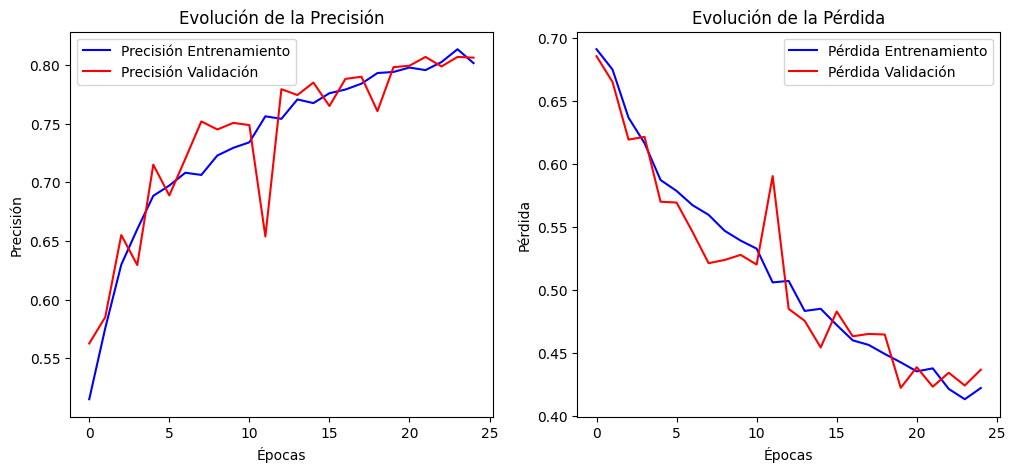

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento', color='blue')
plt.plot(epochs_range, val_acc, label='Precisión Validación', color='red')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Evolución de la Precisión')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento', color='blue')
plt.plot(epochs_range, val_loss, label='Pérdida Validación', color='red')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Evolución de la Pérdida')
plt.legend()

plt.show()

1/1 [==============================] - 0s 24ms/step


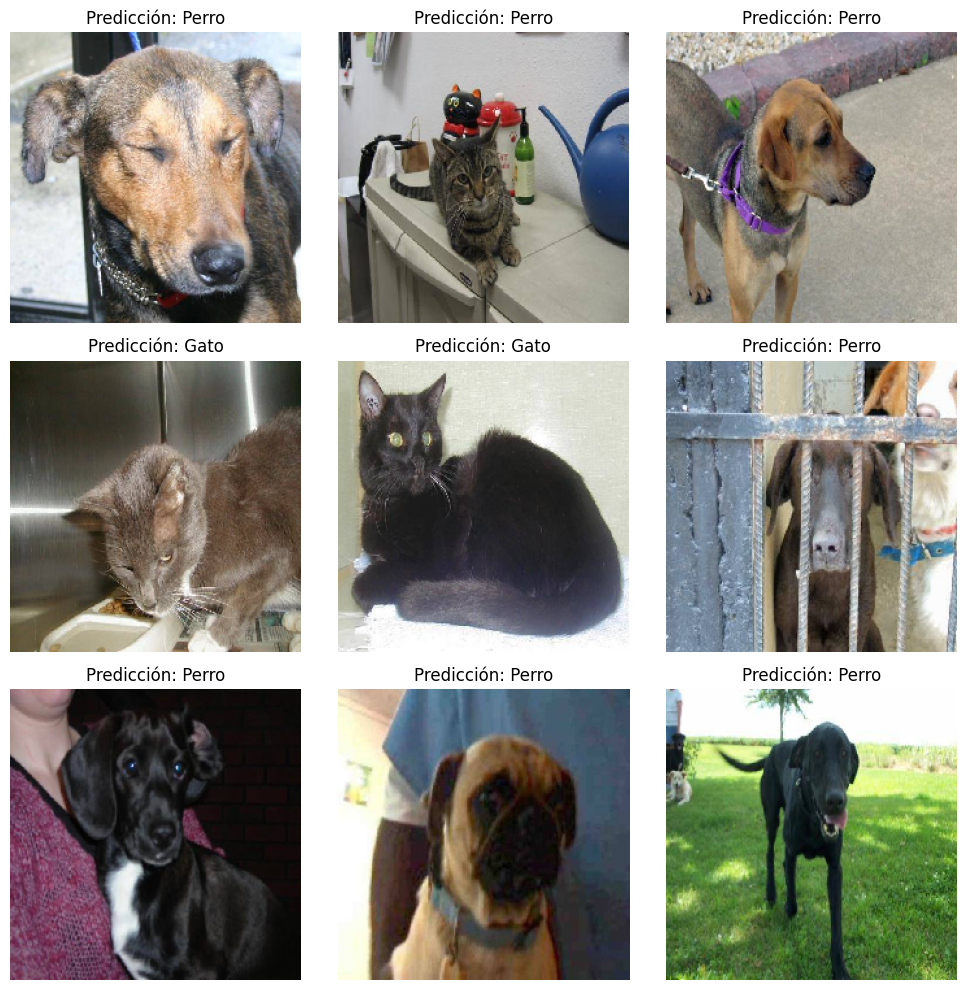

In [ ]:

test_dir = '../data/raw/test/'


def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(200, 200))  
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  
    return img_array

image_paths = [os.path.join(test_dir, img) for img in os.listdir(test_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
random_images = random.sample(image_paths, 9)  # Seleccionar 9 imágenes aleatorias


plt.figure(figsize=(10, 10))

for i, img_path in enumerate(random_images):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)  
    predicted_class = 'Perro' if prediction[0][0] > 0.5 else 'Gato'  
    
    plt.subplot(3, 3, i+1)
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción: {predicted_class}")

plt.tight_layout()
plt.show()


Entiendo que podría haber aumentado las batches y la epoch, pero muchas veces he tenido que pelearme con caídas del kernel y fallos de codespace. 

Me hubiera gustado poder implementarlo en Colab y ver como funciona con GPU, traté d hacerlo funcionar porque tengo una NVIDIA e incluso instale el CUDA, pero perdí mucho tiempo y no conseguí nada. 